In [1]:
#|hide
from fastrl.test_utils import initialize_notebook
initialize_notebook()

In [2]:
#|default_exp learner.core

In [1]:
#|export
# Python native modules
import os
from contextlib import contextmanager
from typing import List,Union
# Third party libs
from fastcore.all import add_docs
import torchdata.datapipes as dp
import torch
from torch import nn
from fastrl.torch_core import evaluating
from torchdata.dataloader2 import DataLoader2
from torchdata.dataloader2.graph import traverse_dps,DataPipeGraph,DataPipe
# Local modules
# from fastrl.core import *
# from fastrl.torch_core import *
from fastrl.pipes.core import find_dp
from fastrl.loggers.core import Record,EpochCollector
# from fastrl.data.dataloader2 import *

# Learner Core
> Core DataPipes for building Learners

In [28]:
#|export
class LearnerBase(dp.iter.IterDataPipe):
    def __init__(self,
            model:nn.Module, # The base NN that we getting raw action values out of.
            dls:List[DataLoader2], # The dataloaders to read data from for training
            device=None,
            loss_func=None, # The loss function to use
            opt=None, # The optimizer to use
            # LearnerBase will yield each dl individually by default. If `zipwise=True`
            # next() will be called on `dls` and will `yield next(dl1),next(dl2),next(dl1)...`
            zipwise:bool=False,
            # For reinforcement learning, the iterables/workers will live forever and so we dont want
            # to shut them down. We still want a concept of "batch" and "epoch" so this param
            # can handle that.
            batches:int=None,
            # If dl is more than 1, we can switch the dl to use when fitting, or a
            # slice of dls
            fit_idx:Union[int,slice]=0
    ):
        self.loss_func = loss_func
        self.opt = opt
        # TODO: DDPG is demonstrating this drawback. We really should support the 
        # use of multiple models. We might possibly want to just embed the opt and loss 
        # in the models also.
        self.model = model
        self.iterable = dls
        self.zipwise = zipwise
        self.learner_base = self
        self.infinite_dls = False
        self.fit_idx = slice(fit_idx,fit_idx+1) if type(fit_idx)==int else fit_idx
        self._dls = None
        if batches is not None: 
            self.batches = batches
            self.infinite_dls = True
        else:                   
            self.batches = find_dp(traverse_dps(dls[0].datapipe),dp.iter.Header).limit

    def __getstate__(self):
        state = {k:v for k,v in self.__dict__.items() if k not in ['_dls','opt','iterable']}
        # TODO: Needs a better way to serialize / deserialize states.
        # state['iterable'] = [d.state_dict() for d in state['iterable']]
        if dp.iter.IterDataPipe.getstate_hook is not None:
            return dp.iter.IterDataPipe.getstate_hook(state)

        return state

    def __setstate__(self, state):
        # state['iterable'] = [d.from_state_dict() for d in state['iterable']]
        for k,v in state.items():
            setattr(self,k,v)

    def reset(self):
        if not self.infinite_dls:
            self._dls = [iter(dl) for dl in self.iterable]
        elif self._dls is None:
            self._dls = [iter(dl) for dl in self.iterable]
            
    def increment_batch(self,value):
        return not isinstance(value,
            (Record,)
        )
        # return not isinstance(value,
        #     (Record,GetInputItemResponse)
        # )
            
    def __iter__(self):
        self.reset()
        exhausted = []
        zip_list = []
        dl_batch_tracker = [0 for _ in self._dls[self.fit_idx]]
        while len(exhausted)!=len(self._dls[self.fit_idx]):
            # zip_list = []
            for i,dl in enumerate(self._dls[self.fit_idx]):
                if self.zipwise:

                            if i in exhausted: 
                                zip_list.append(None)
                            else:              
                                try: 
                                    zip_list.append(next(dl))
                                    if self.increment_batch(zip_list[-1]): dl_batch_tracker[i]+=1
                                    if self.infinite_dls and dl_batch_tracker[i]>=self.batches:
                                        raise StopIteration
                                except StopIteration:
                                    exhausted.append(i)
                                    zip_list.append(None)
                else:
            # while len(exhausted)!=len(self._dls[self.fit_idx]):
            #     for i,dl in enumerate(self._dls[self.fit_idx]): 
                    while i not in exhausted:
                        try:
                            v = next(dl)
                            if self.increment_batch(v): dl_batch_tracker[i]+=1
                            yield v
                            if self.infinite_dls and dl_batch_tracker[i]>=self.batches:
                                raise StopIteration
                        except StopIteration:
                            exhausted.append(i)

add_docs(
LearnerBase,
"Combines models,dataloaders, and optimizers together for running a training pipeline.",
reset="""If `infinite_dls` is false, then all dls will be reset, otherwise they will be
kept alive.""",
increment_batch="Decides when a single batch is actually 'complete'."
)

In [29]:
#|export
class LearnerHead(dp.iter.IterDataPipe):
    def __init__(self,source_datapipe):
        self.source_datapipe = source_datapipe
        self.learner_base = find_dp(traverse_dps(self.source_datapipe),LearnerBase)

    def __iter__(self): yield from self.source_datapipe
    
    def fit(self,epochs):
        epocher = find_dp(traverse_dps(self),EpochCollector)
        epocher.epochs = epochs
        
        for iteration in self: 
            pass

    def validate(self,epochs=1,dl_idx=1) -> DataPipe:
        with evaluating(self.learner_base.model):
            for epoch in range(epochs):
                for el in self.learner_base.iterable[dl_idx]:pass 

            pipe = self.learner_base.iterable[dl_idx].datapipe
            return pipe.show() if hasattr(pipe,'show') else pipe
        
add_docs(
LearnerHead,
"""
""",
fit="Runs the `LearnerHead` pipeline for `epochs`",
validate="""If there is more than 1 dl, then run 1 epoch of that dl based on 
`dl_idx` and returns the original datapipe for displaying."""
)  

> Warning: Pickling the LearnerBase will exclude the '_dls','opt','iterable' fields since
these aren't easily picklable (yet).

In [30]:
# from fastrl.torch_core import *
from fastrl.agents.dqn.basic import DQN
from fastrl.agents.core import AgentBase,AgentHead,StepFieldSelector,SimpleModelRunner,NumpyConverter
from fastrl.agents.discrete import ArgMaxer,PyPrimativeConverter
# from fastrl.data.block import *
from fastrl.envs.gym import GymDataPipe
# from fastrl.loggers.vscode_visualizers import *

In [31]:
# Setup up the core NN
torch.manual_seed(0)
model = DQN(4,2)
# Setup the agent
agent = AgentBase(model,[])
agent = StepFieldSelector(agent,field='state')
# All the things that make this agent unique and special
# In this instance, all this module does is pass the action directly through to the model.
agent = SimpleModelRunner(agent)
agent = ArgMaxer(agent,only_idx=True)
agent = NumpyConverter(agent)
agent = PyPrimativeConverter(agent)
# Bring everything together into the AgentHead where actions will be passed and then run through the pipeline
agent = AgentHead(agent)

In [32]:
from fastrl.loggers.vscode_visualizers import VSCodePipeline
from torchdata.dataloader2 import DataLoader2,MultiProcessingReadingService

In [33]:
# Setup the DataBlock
# block = DataBlock(
#     GymTransformBlock(agent=agent,nsteps=1,nskips=1,firstlast=False,n=100,bs=1),
#     (GymTransformBlock(agent=agent,nsteps=1,nskips=1,firstlast=False,n=100,bs=1,include_images=True),VSCodeTransformBlock())
# )
def gym_block(elements,num_workers,vis=False):
    pipe = GymDataPipe(elements,agent=agent,nsteps=1,nskips=1,firstlast=False,include_images=True,n=100,bs=1)
    if vis:
        pipe = VSCodePipeline(pipe)
    dl = DataLoader2(pipe,
        reading_service=MultiProcessingReadingService(num_workers = num_workers)
    )
    return dl

dls = (gym_block(['CartPole-v1']*1,num_workers=0),gym_block(['CartPole-v1']*1,num_workers=0,vis=True))


/usr/local/lib/python3.8/dist-packages/torchdata/dataloader2/reading_service.py:287: UserWarning: Please use `InProcessReadingService` for num_workers=0
  warnings.warn("Please use `InProcessReadingService` for num_workers=0")


In [34]:
def TestLearner(model,dls):
    learner = LearnerBase(model,dls)
    learner = LearnerHead(learner)
    return learner

In [35]:
import pickle

In [36]:
learner = TestLearner(model,dls)

out = pickle.dumps(learner)
pickle.loads(out)

LearnerHead

No protocol specified


/home/fastrl_user/fastrl/fastrl/envs/gym.py:121: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state=torch.tensor(step.next_state),


Creating gif from 100 frames


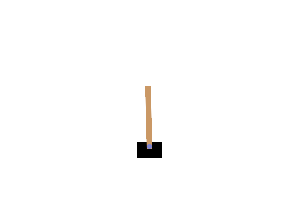

In [13]:
#|hide
#|eval: false
learner.validate(1)

In [14]:
#|export
class StepBatcher(dp.iter.IterDataPipe):
    def __init__(self,
            source_datapipe,
            device=None
        ):
        self.source_datapipe = source_datapipe
        self.device = device
        
    def vstack_by_fld(self,batch,fld):
        try:
            if self.device is None: return torch.vstack(tuple(getattr(step,fld) for step in batch))
            return torch.vstack(tuple(getattr(step,fld) for step in batch)).to(torch.device(self.device))
        except RuntimeError as e:
            print(f'Failed to stack {fld} given batch: {batch}')
            raise
        
    def __iter__(self):
        for batch in self.source_datapipe:
            cls = batch[0].__class__
            yield cls(**{fld:self.vstack_by_fld(batch,fld) for fld in cls._fields})

add_docs(
StepBatcher,
"Converts multiple `StepType` into a single `StepType` with the fields concated.",
vstack_by_fld="vstacks a `fld` in `batch`"
)

In [2]:
#|hide
#|eval: false
!nbdev_export

/usr/local/lib/python3.8/dist-packages/nbdev/export.py:54: UserWarning: Notebook '/home/fastrl_user/fastrl/nbs/07_Agents/02_Continuous/12u_agents.ppo.ipynb' uses `#|export` without `#|default_exp` cell.
Note nbdev2 no longer supports nbdev1 syntax. Run `nbdev_migrate` to upgrade.
See https://nbdev.fast.ai/getting_started.html for more information.
  warn(f"Notebook '{nbname}' uses `#|export` without `#|default_exp` cell.\n"
